<a href="https://colab.research.google.com/github/karan734079/flappy/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load and preprocess the Fashion MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = (train_images - 127.5) / 127.5  # Normalize the images to the range [-1, 1]
train_images = np.expand_dims(train_images, axis=-1)

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Define the generator model
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(7 * 7 * 256, input_dim=latent_dim))
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2DTranspose(1, kernel_size=7, activation='tanh', padding='same'))
    return model

In [ ]:
# Define the discriminator model
def build_discriminator(img_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
# Build and compile the discriminator
img_shape = (28, 28, 1)
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

In [ ]:
# Build the generator
latent_dim = 100
generator = build_generator(latent_dim)

In [ ]:
# Build and compile the combined model (generator and discriminator)
discriminator.trainable = False
gan_input = tf.keras.Input(shape=(latent_dim,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)
gan = tf.keras.models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

In [ ]:
# Function to train the GAN
def train_gan(epochs, batch_size):
    batch_count = train_images.shape[0] // batch_size

    for epoch in range(epochs):
        for _ in range(batch_count):
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            generated_images = generator.predict(noise)
            real_images = train_images[np.random.randint(0, train_images.shape[0], batch_size)]

            labels_real = np.ones((batch_size, 1))
            labels_fake = np.zeros((batch_size, 1))

            d_loss_real = discriminator.train_on_batch(real_images, labels_real)
            d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            labels_gan = np.ones((batch_size, 1))

            g_loss = gan.train_on_batch(noise, labels_gan)

        print(f'Epoch {epoch + 1}/{epochs}, D Loss: {d_loss[0]}, G Loss: {g_loss}')


In [ ]:
# Train the GAN
epochs = 1
batch_size = 64
train_gan(epochs, batch_size)

2/2 [==============================] - 0s 8ms/step
Epoch 1/1, D Loss: 0.6916488707065582, G Loss: 0.7129110097885132


In [ ]:
# Generate and plot images
def generate_images(generator, latent_dim, n_samples=25):
    noise = np.random.normal(0, 1, size=(n_samples, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale values to [0, 1]

    fig, axs = plt.subplots(5, 5)
    count = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(generated_images[count, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            count += 1
    plt.show()

1/1 [==============================] - 0s 458ms/step


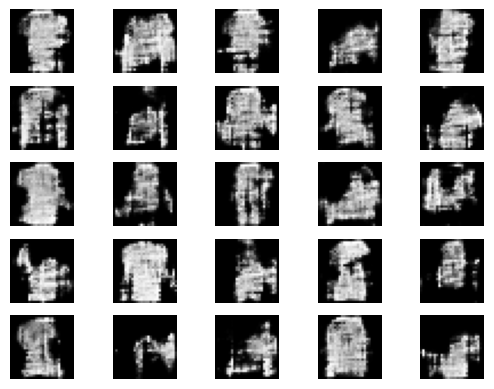

In [ ]:
# Generate and plot images
generate_images(generator, latent_dim)